In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("airline-passengers.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## EDA

In [ ]:
df.shape

(144, 2)

In [ ]:
#Checking the data types
df.dtypes

Month         object
Passengers     int64
dtype: object

In [ ]:
df.isna().any()

Month         False
Passengers    False
dtype: bool

In [ ]:
df.isna().sum()

Month         0
Passengers    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


<Axes: >

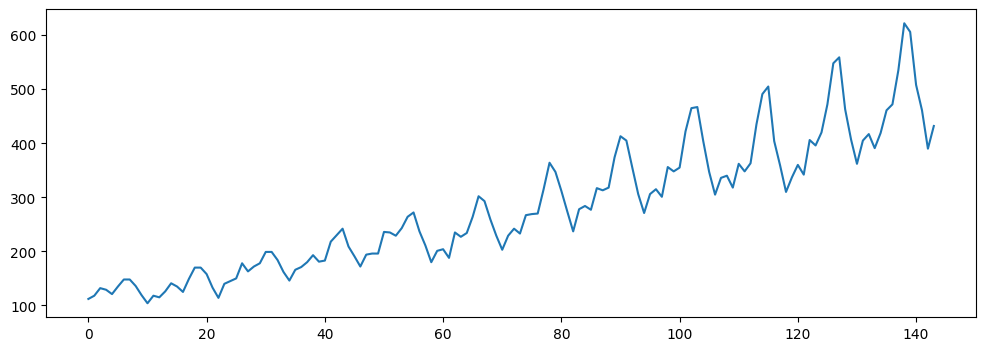

In [ ]:
df['Passengers'].plot(figsize=(12,4))

## Feature Engineering

In [ ]:
# Converting 'Month' column to datetime and adding MonthEnd offset
df['Date'] = pd.to_datetime(df['Month']) + pd.offsets.MonthEnd(0)
df

,Month,Passengers,Date
0,1949-01,112,1949-01-31
1,1949-02,118,1949-02-28
2,1949-03,132,1949-03-31
3,1949-04,129,1949-04-30
4,1949-05,121,1949-05-31
...,...,...,...
139,1960-08,606,1960-08-31
140,1960-09,508,1960-09-30
141,1960-10,461,1960-10-31
142,1960-11,390,1960-11-30


In [ ]:
# Splitting the 'Month' column into 'Year' and 'Month' columns
df[['Year', 'Month']] = df['Month'].str.split('-', expand=True)

# Converting numeric month values to month names
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.strftime('%b')
df

,Month,Passengers,Date,Year
0,Jan,112,1949-01-31,1949
1,Feb,118,1949-02-28,1949
2,Mar,132,1949-03-31,1949
3,Apr,129,1949-04-30,1949
4,May,121,1949-05-31,1949
...,...,...,...,...
139,Aug,606,1960-08-31,1960
140,Sep,508,1960-09-30,1960
141,Oct,461,1960-10-31,1960
142,Nov,390,1960-11-30,1960


## Data Visualization

<Axes: xlabel='Month', ylabel='Year'>

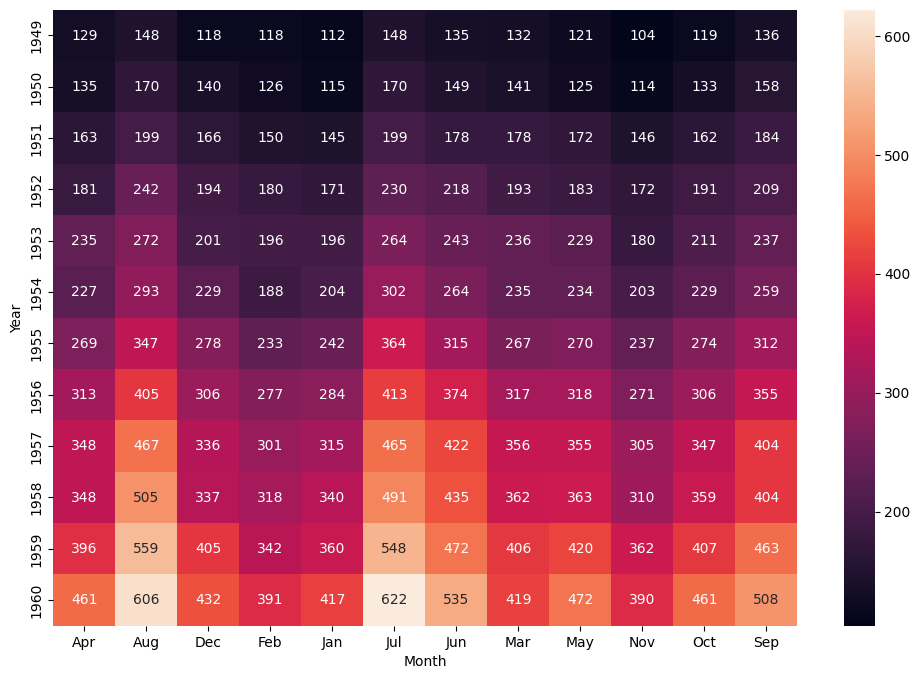

In [ ]:
# Heatmap
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Passengers",index="Year",columns="Month",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

### Histogram and Density plot

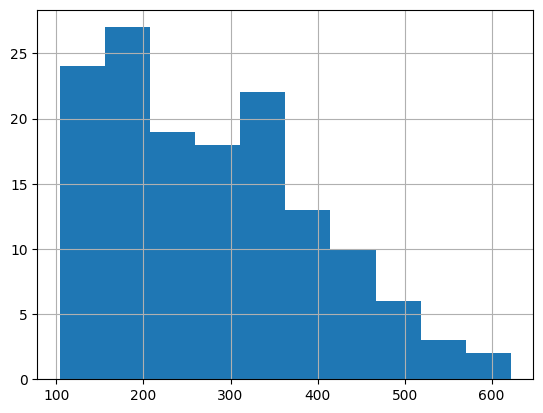

In [ ]:
df['Passengers'].hist()
pyplot.show()

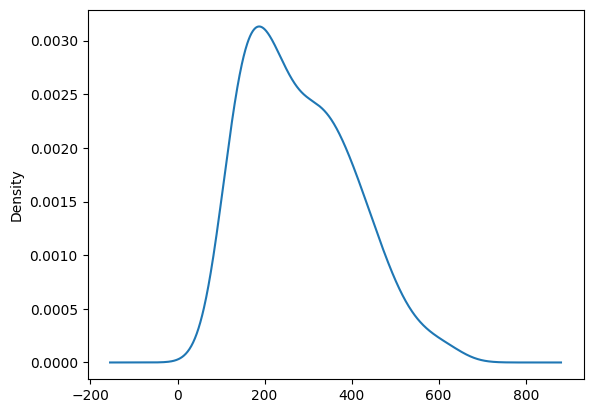

In [ ]:
df['Passengers'].plot(kind='kde')
pyplot.show()

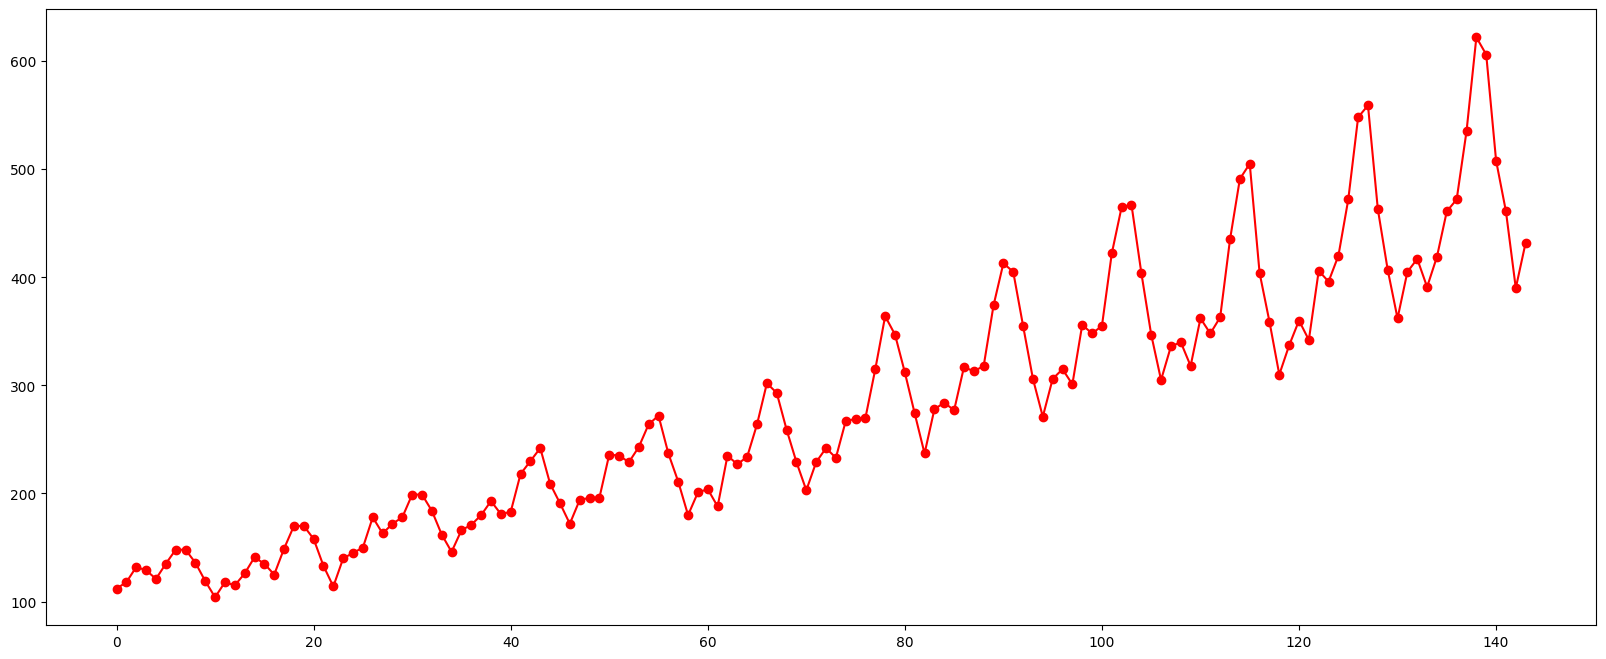

In [ ]:
df['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

We can see that there is an increasing trend and the variance is also not constant

<Axes: xlabel='Month', ylabel='Passengers'>

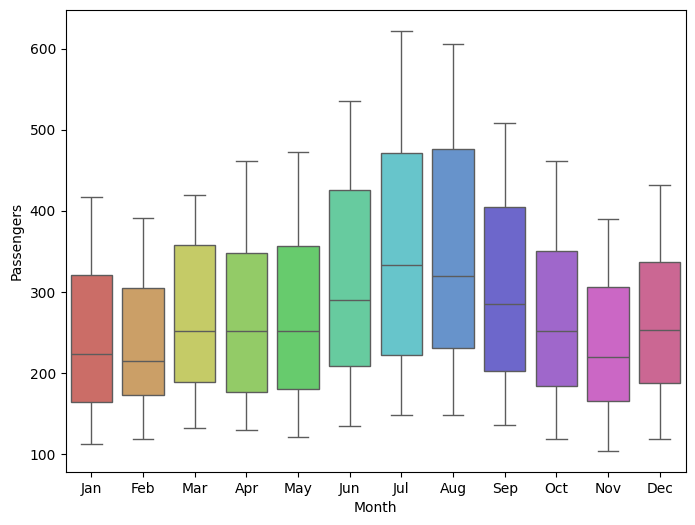

In [ ]:
# Boxplot for month-wise
plt.figure(figsize=(8,6))
sns.boxplot(x="Month",y="Passengers",data=df, palette = 'hls')

<Axes: xlabel='Year', ylabel='Passengers'>

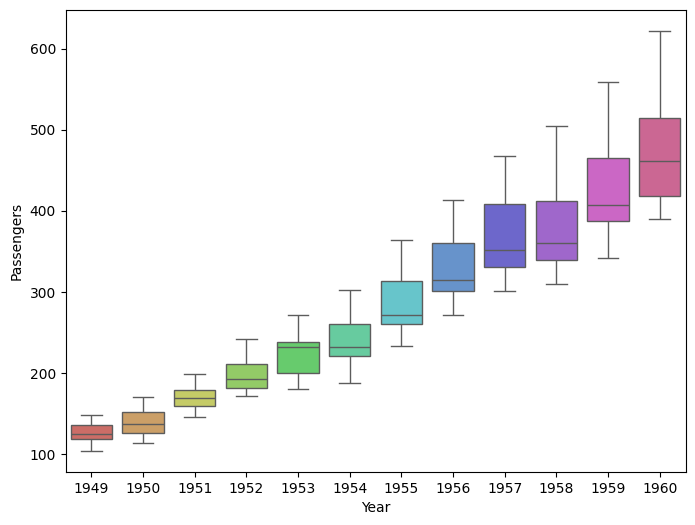

In [ ]:
# Boxplot for year-wise
plt.figure(figsize=(8,6))
sns.boxplot(x="Year",y="Passengers",data=df, palette = 'hls')

##### **Observation** : We can see that there are no outliers in our data

### Line Plot

<Axes: xlabel='Year', ylabel='Passengers'>

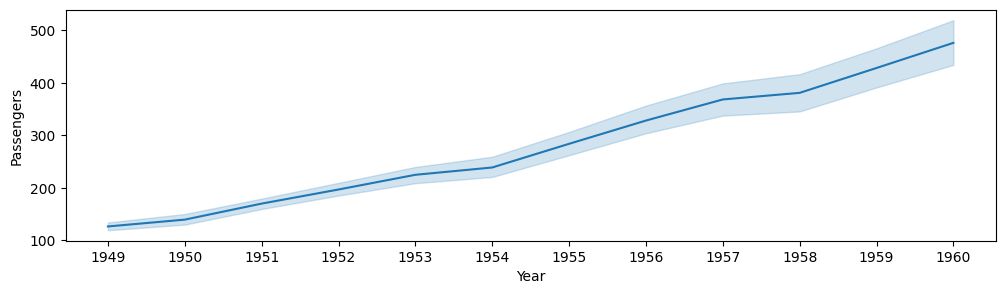

In [ ]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Year",y="Passengers",data = df)

### Lag plot

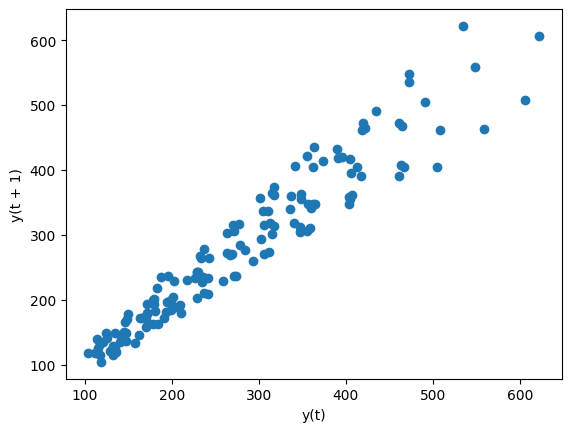

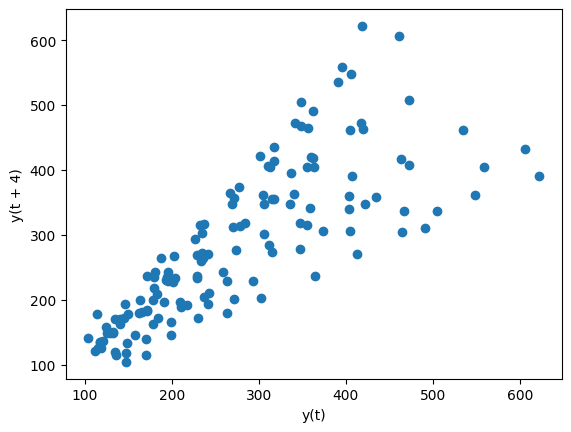

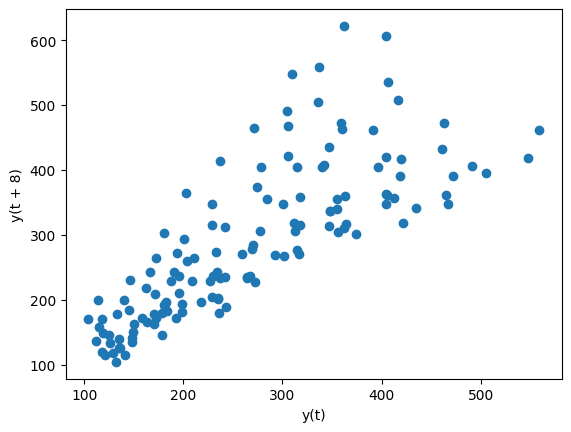

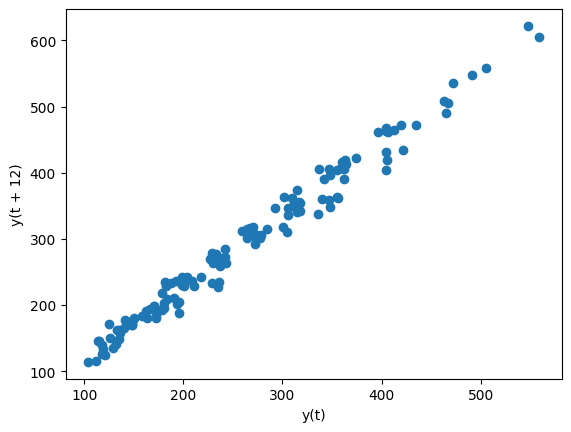

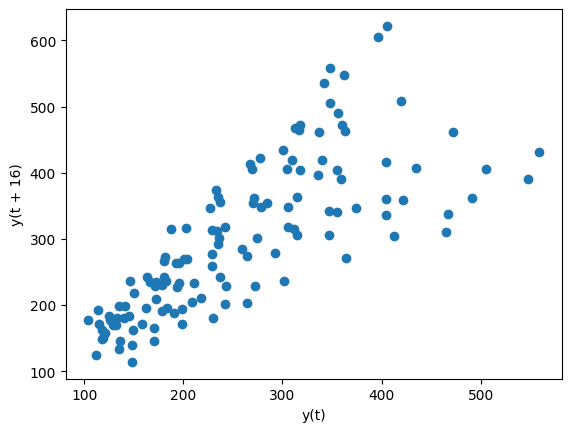

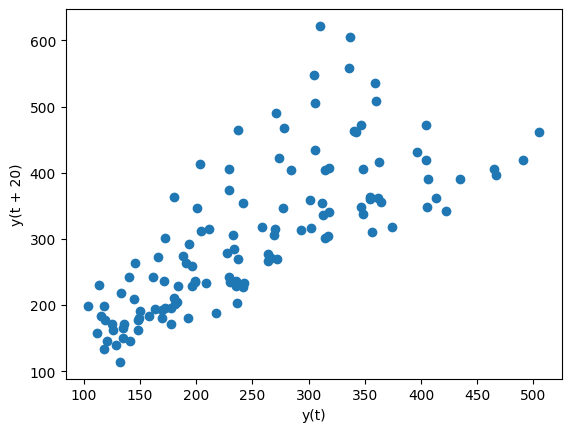

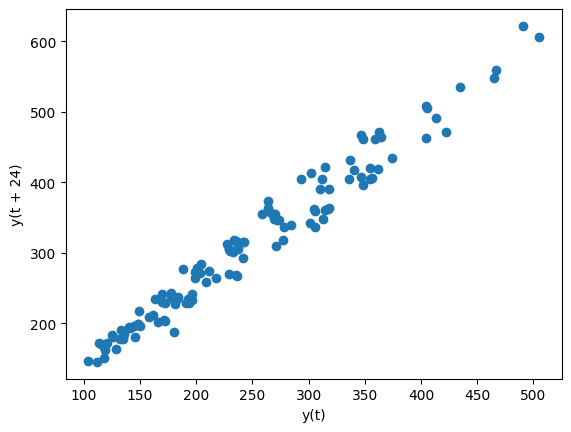

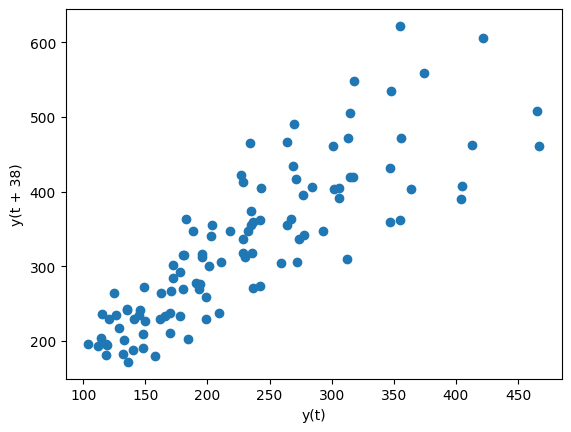

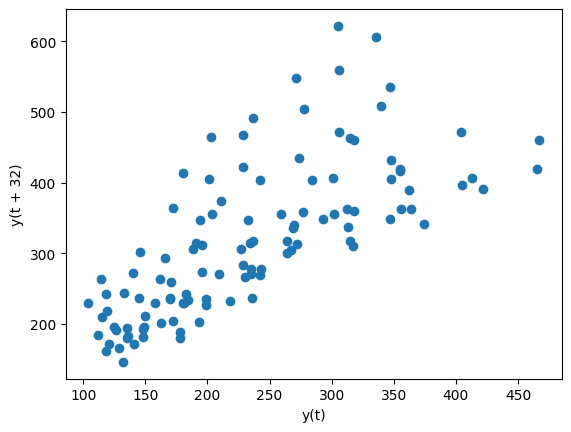

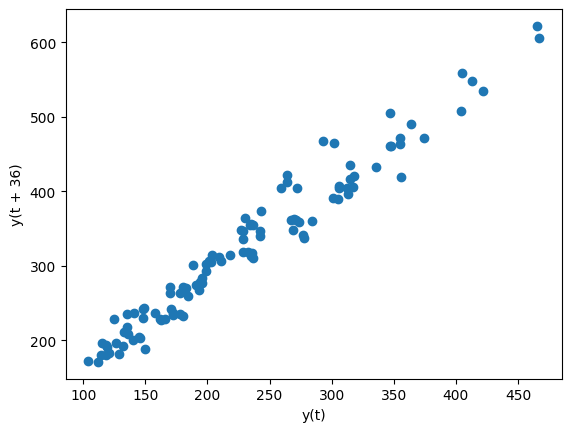

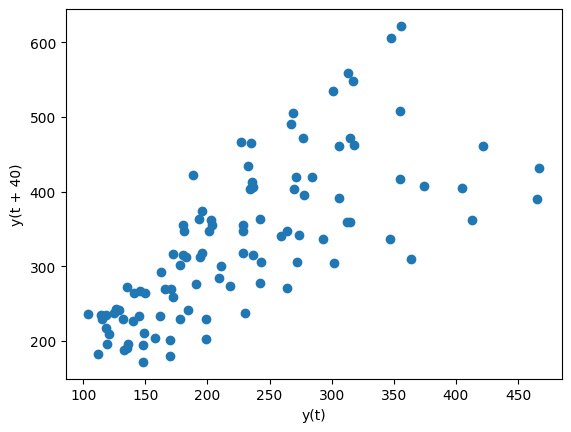

In [ ]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

## Moving Average

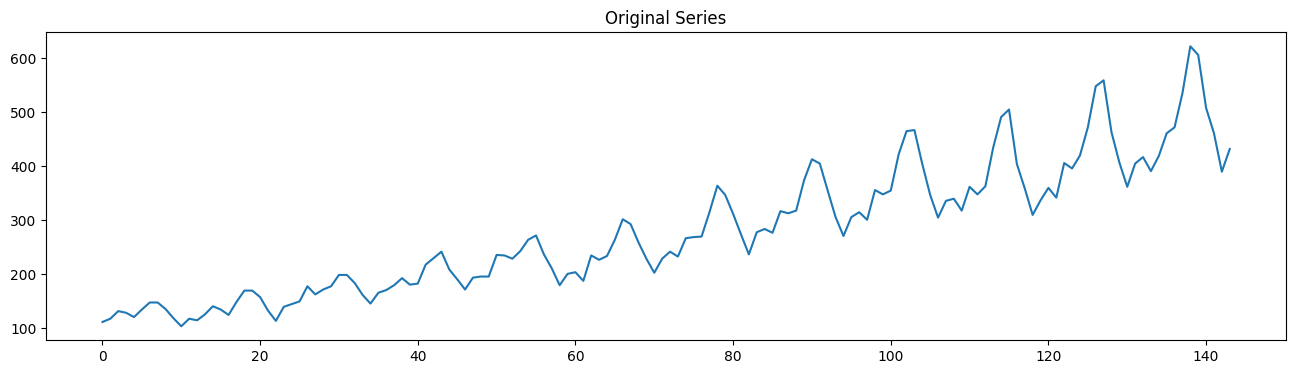

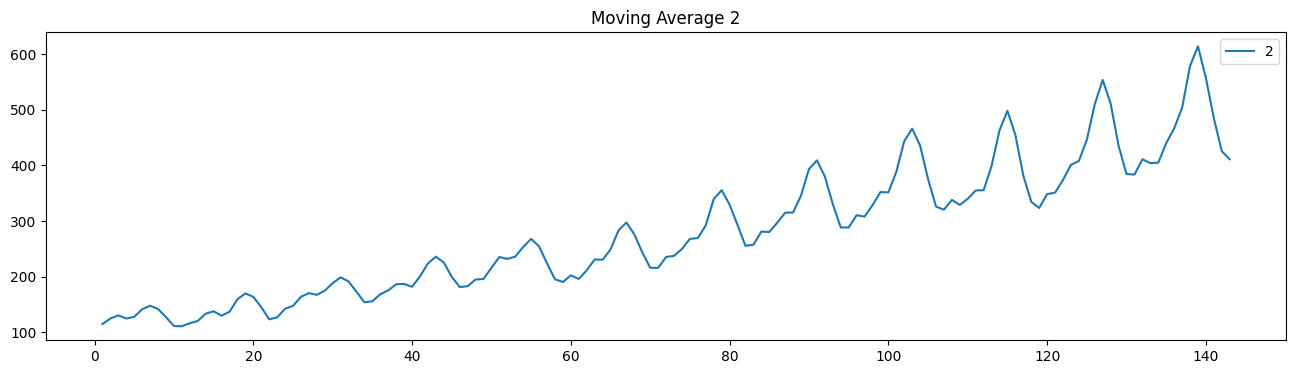

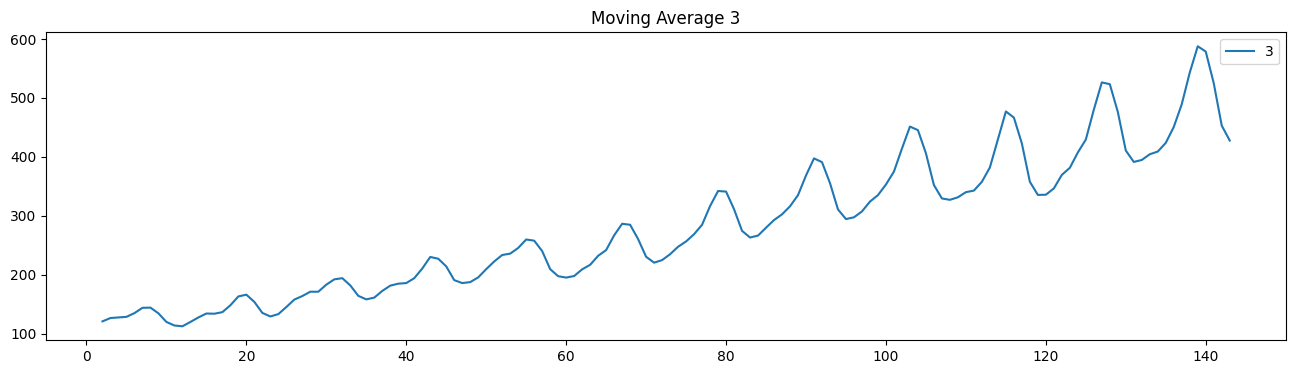

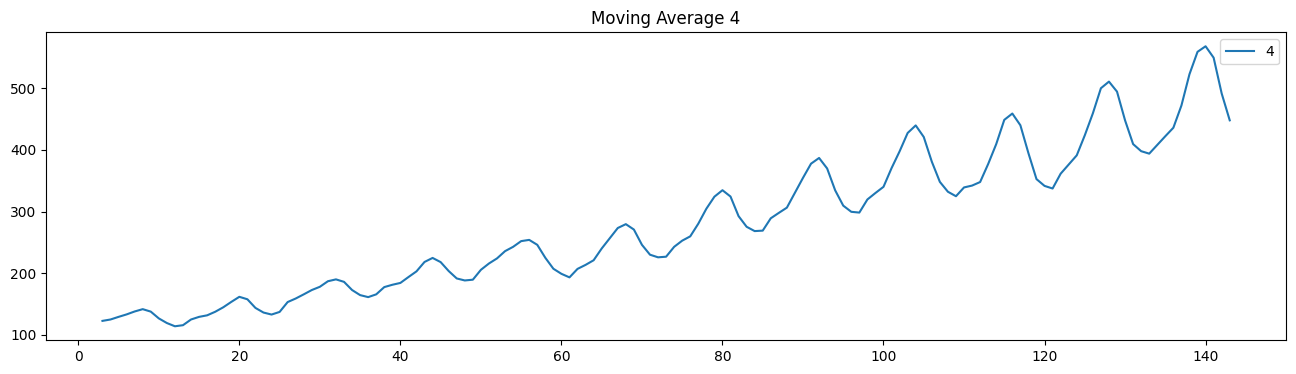

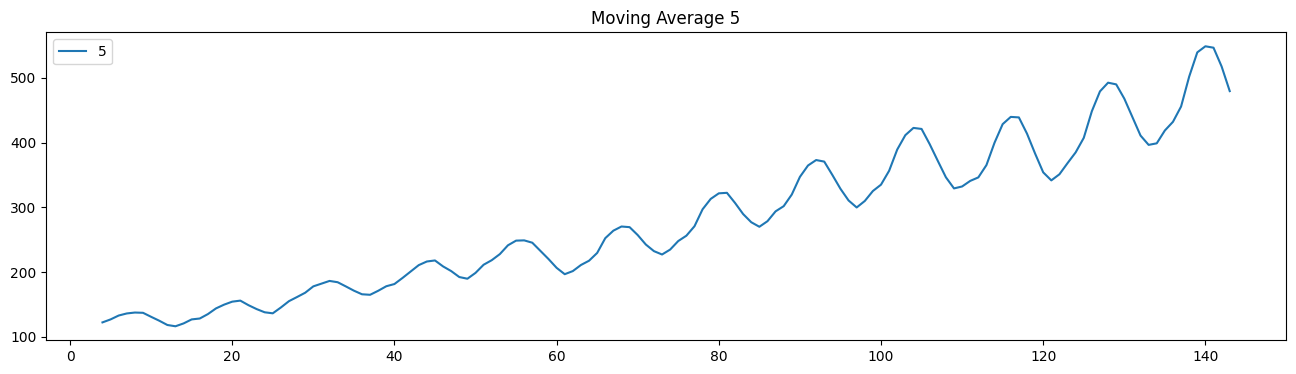

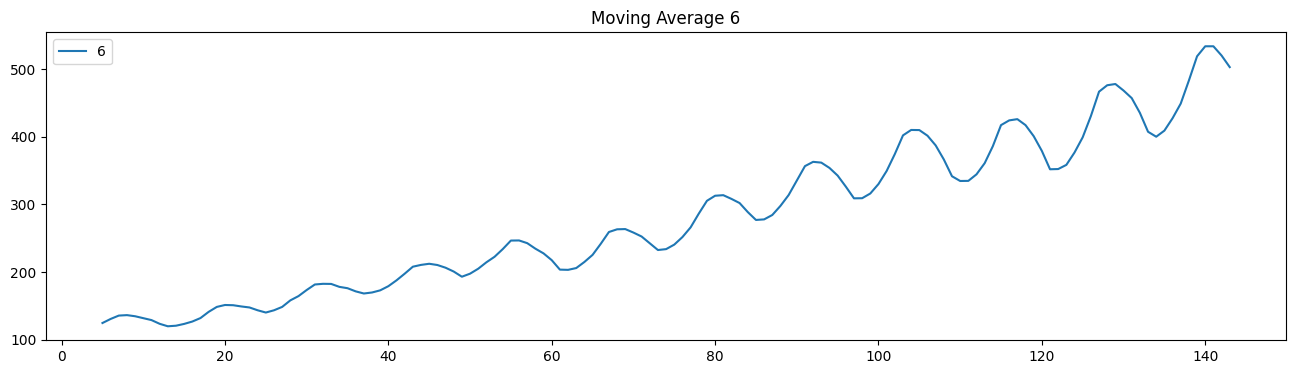

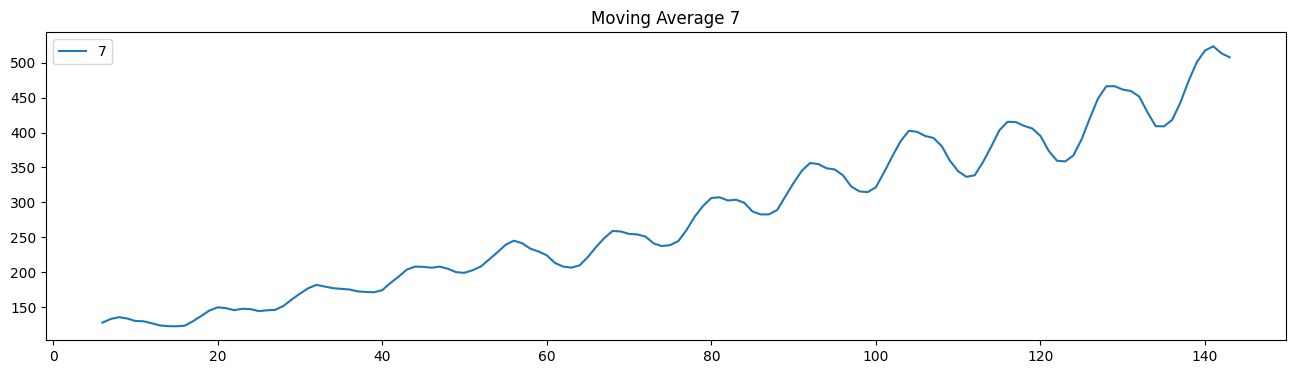

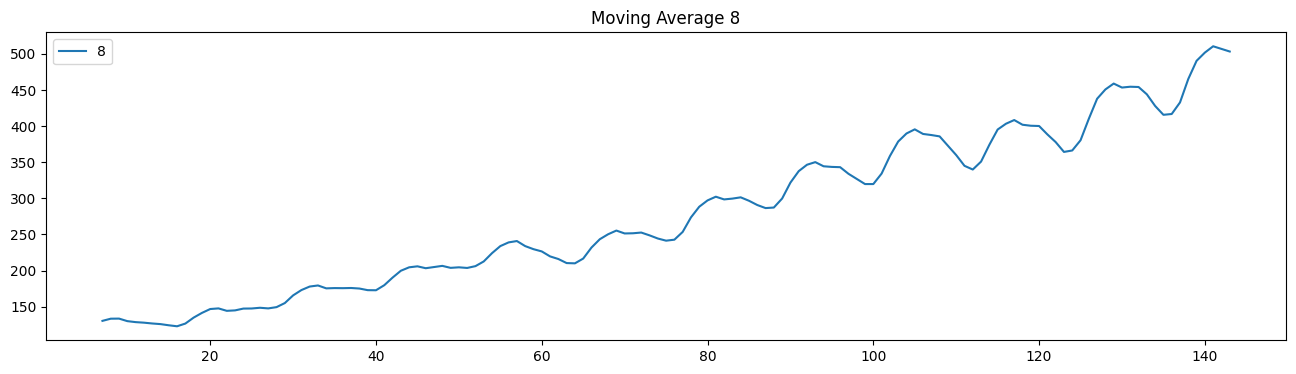

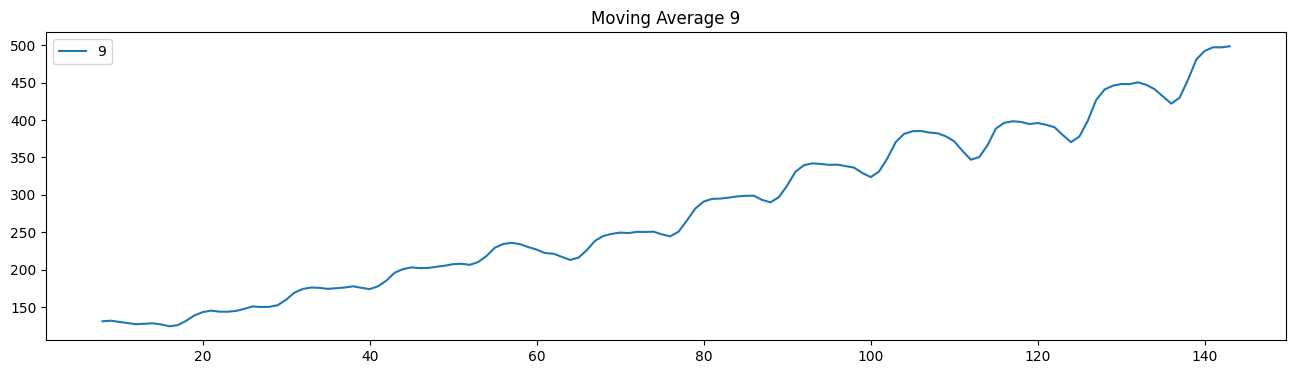

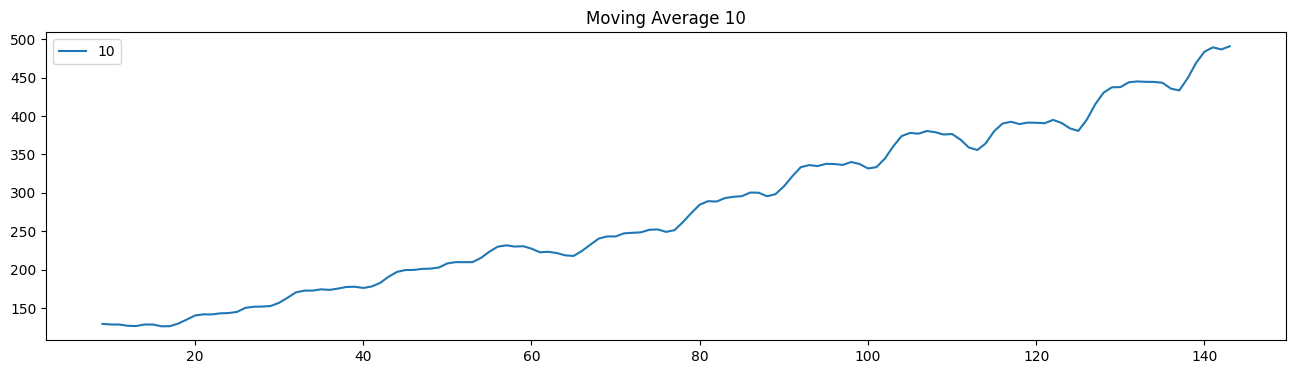

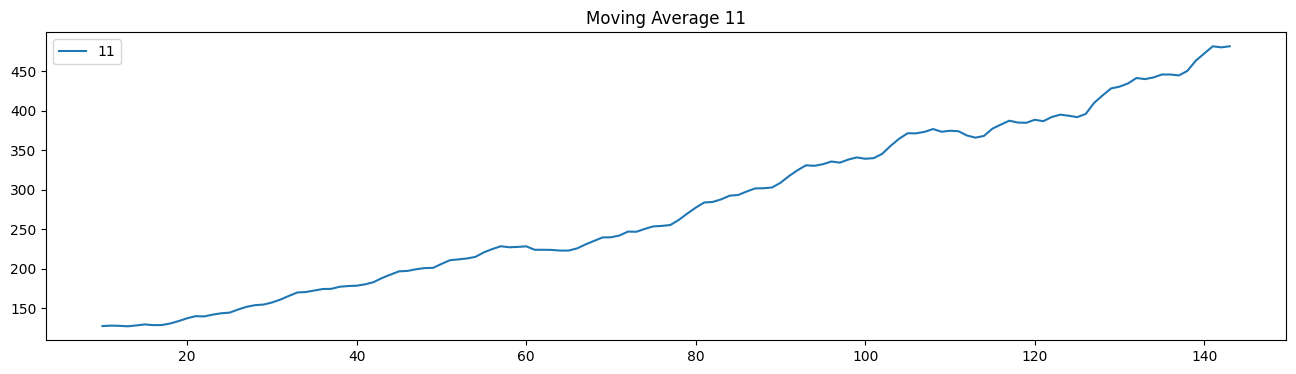

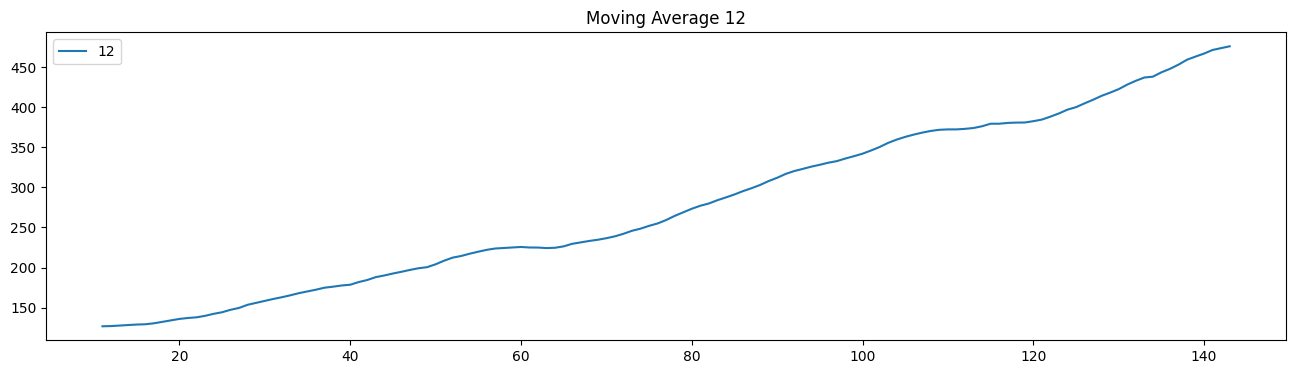

In [ ]:
plt.figure(figsize=(16,4))
df['Passengers'].plot(label="org")
plt.title("Original Series")

for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

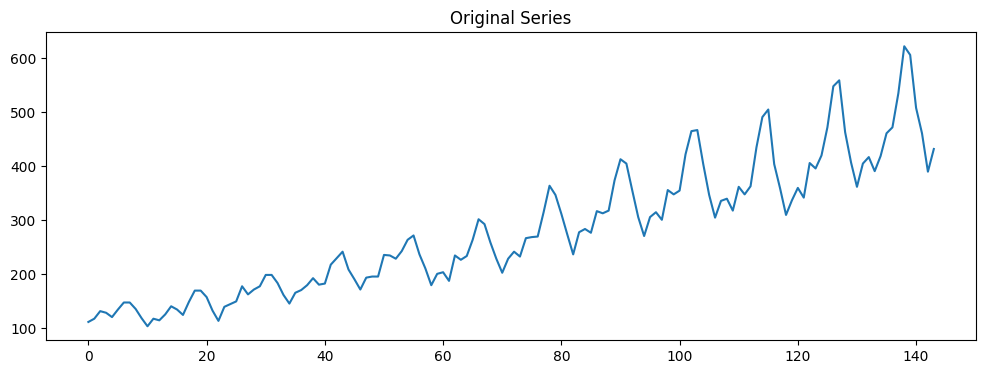

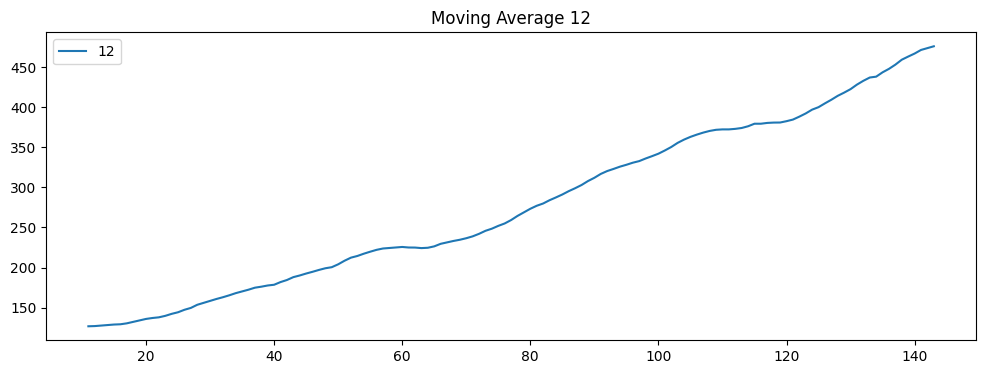

In [ ]:
# Original Data
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))

# Moving average 12
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

## Time Series Decomposition plot

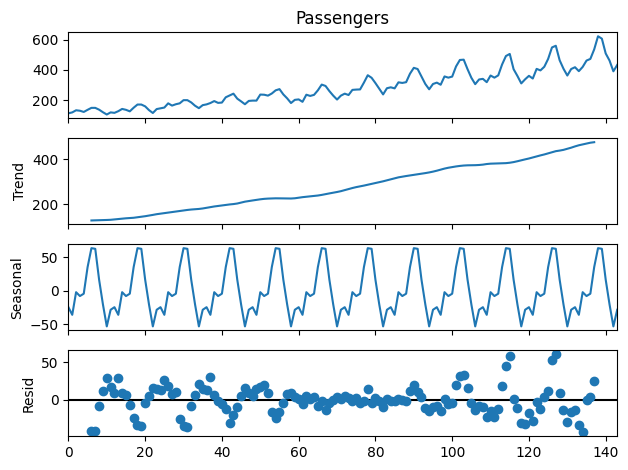

In [ ]:
# Additive model
decompose_ts_add = seasonal_decompose(df['Passengers'], model = 'additive', period=12) # Assuming monthly data, so period=12
decompose_ts_add.plot()
plt.show()

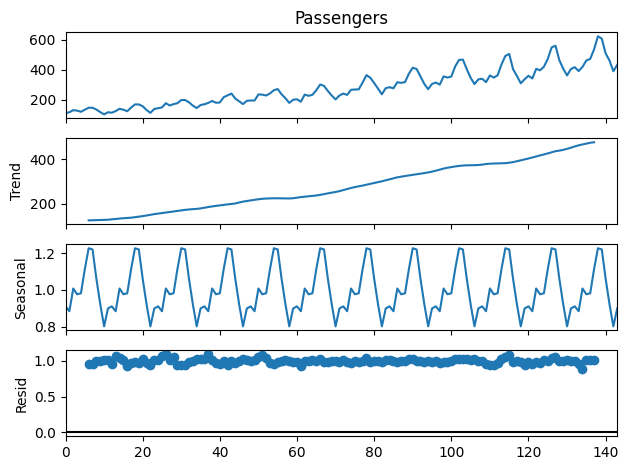

In [ ]:
# Multiplicative model
decompose_ts_mul = seasonal_decompose(df['Passengers'], model = 'multiplicative', period=12) # Assuming monthly data, so period=12
decompose_ts_mul.plot()
plt.show()

# ACF plots and PACF plots


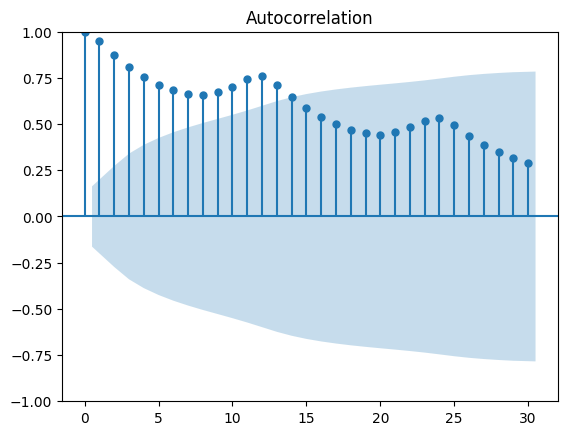

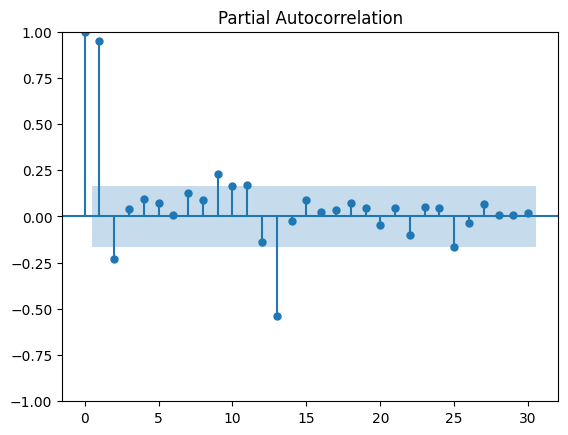

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=30)
tsa_plots.plot_pacf(df.Passengers,lags=30)
plt.show()

### **Data Partition**

##### Utilizing the last 2 Years for Testing Purpose.

In [ ]:
size = -24

# Partition the data into train and test sets
Train = df.iloc[:size]
Test = df.iloc[size:]

In [ ]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 120
Test set length: 24


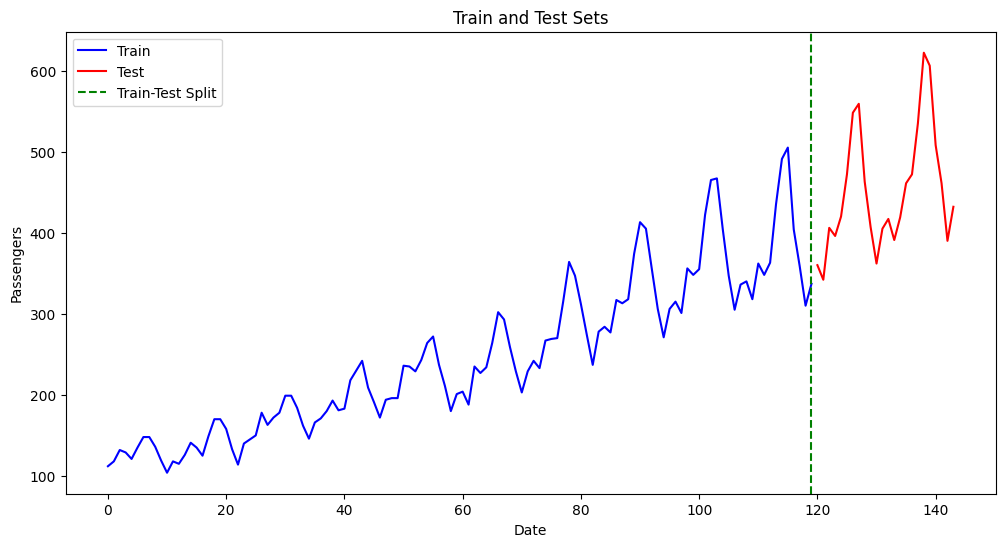

In [ ]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Passengers'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Passengers'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Building Forecasting models

### Evaluation Metric MAPE

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method


##### Hyperparameter tuning

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Define a range of values for alpha
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different values of alpha
mape_scores = []

# Iterate over all values of alpha
for alpha in alphas:
    # Fit the model with current value of alpha
    ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=alpha)

    # Generate predictions
    pred_ses = ses_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_ses, Test["Passengers"])

    # Store the MAPE score and alpha value
    mape_scores.append((mape, alpha))

# Find the alpha value with the lowest MAPE
best_mape, best_alpha = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best alpha:", best_alpha)

Best MAPE: 16.426711214606787
Best alpha: 0.2


In [ ]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=best_alpha)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

16.426711214606787

In [ ]:
rmse_ses = np.sqrt(mean_squared_error(Test["Passengers"], pred_ses))
print("Root Mean Squared Error (RMSE):", rmse_ses)

Root Mean Squared Error (RMSE): 107.51801843252042


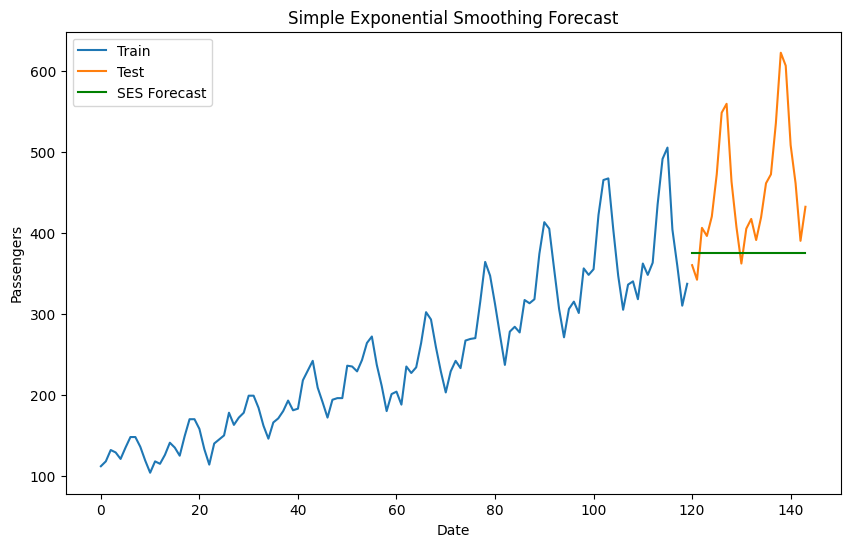

In [ ]:

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_ses, label='SES Forecast', color='green')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Holt method

##### Hyperparameter tuning

In [ ]:
import numpy as np
from statsmodels.tsa.holtwinters import Holt
from itertools import product

# Define a range of values for smoothing_level and smoothing_slope
smoothing_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
smoothing_slopes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different combinations of parameters
mape_scores = []

# Iterate over all combinations of parameters
for smoothing_level, smoothing_slope in product(smoothing_levels, smoothing_slopes):
    # Fit the model with current parameter combination
    hw_model = Holt(Train["Passengers"]).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    # Generate predictions
    pred_hw = hw_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_hw, Test["Passengers"])

    # Store the MAPE score and parameter combination
    mape_scores.append((mape, smoothing_level, smoothing_slope))

# Find the parameter combination with the lowest MAPE
best_mape, best_smoothing_level, best_smoothing_slope = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best smoothing_level:", best_smoothing_level)
print("Best smoothing_slope:", best_smoothing_slope)

Best MAPE: 11.328891006520138
Best smoothing_level: 0.1
Best smoothing_slope: 0.1


In [ ]:
# Holt method
hw_model = Holt(Train["Passengers"]).fit(smoothing_level = best_smoothing_level,
                                         smoothing_slope = best_smoothing_slope)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :',MAPE(pred_hw,Test.Passengers))

MAPE : 11.328891006520138


In [ ]:
rmse_hw_model = np.sqrt(mean_squared_error(Test["Passengers"], pred_hw))
print("Root Mean Squared Error (RMSE):", rmse_hw_model)

Root Mean Squared Error (RMSE): 78.90685269837014


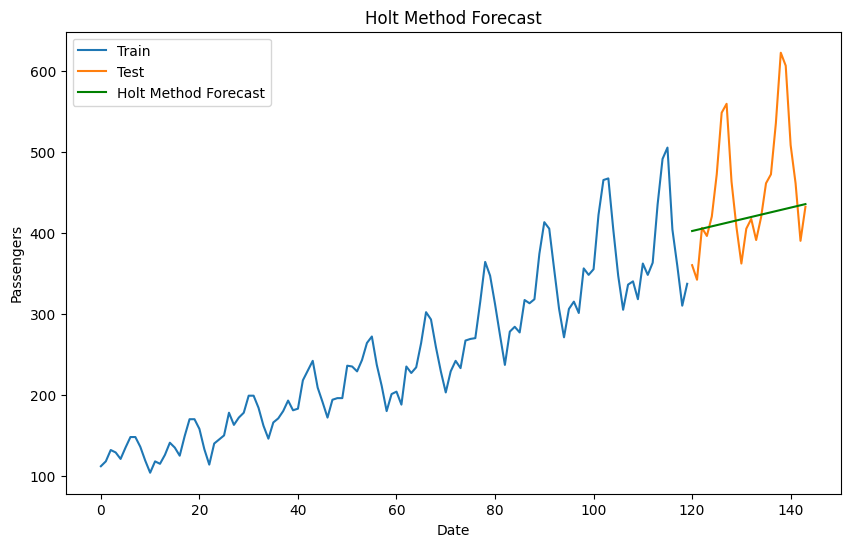

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hw, label='Holt Method Forecast', color='green')
plt.title('Holt Method Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### Holts winter exponential smoothing with additive seasonality and additive trend

In [ ]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :', MAPE(pred_hwe_add_add,Test.Passengers))

MAPE : 6.636014405974623


In [ ]:
rmse_hwe_model_add_add = np.sqrt(mean_squared_error(Test["Passengers"], pred_hwe_add_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_add_add)

Root Mean Squared Error (RMSE): 35.757539410127215


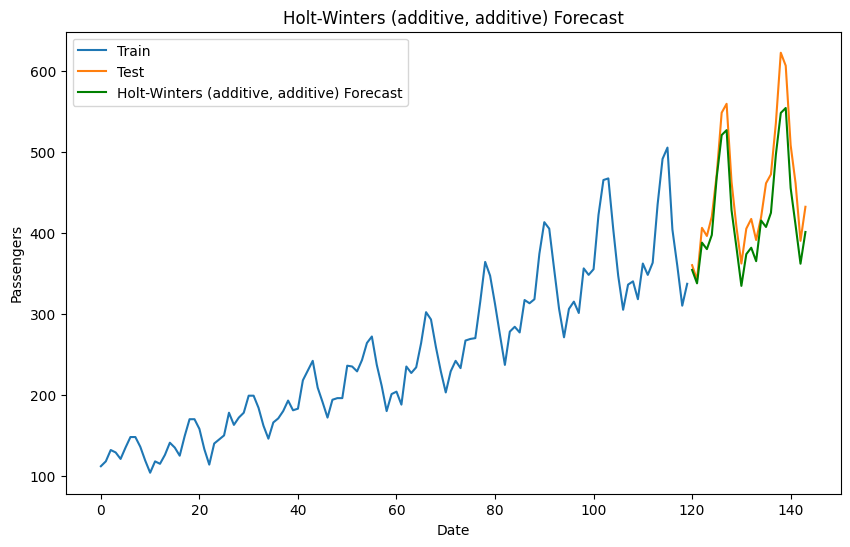

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hwe_add_add, label='Holt-Winters (additive, additive) Forecast', color='green')
plt.title('Holt-Winters (additive, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [ ]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

6.390945442443964

In [ ]:
rmse_hwe_model_mul_add = np.sqrt(mean_squared_error(Test["Passengers"], pred_hwe_mul_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_mul_add)

Root Mean Squared Error (RMSE): 32.48818087105796


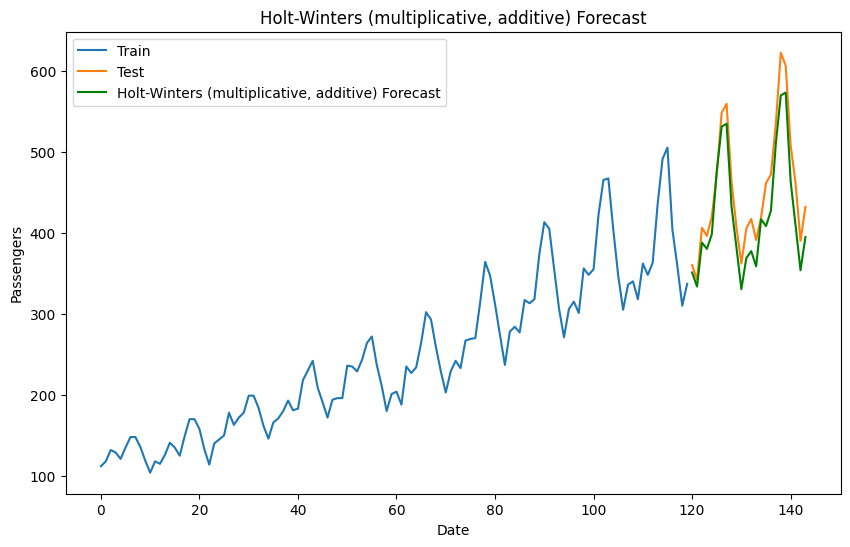

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hwe_mul_add, label='Holt-Winters (multiplicative, additive) Forecast', color='green')
plt.title('Holt-Winters (multiplicative, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Auroregressive Inregrated Moving Average (ARIMA)

##### Hyperparameter Tuning for ARIMA

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the range of p, d, and q values
p_values = range(0, 5)  # AR order
d_values = range(0, 5)  # Differencing order
q_values = range(0, 5)  # MA order

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p_values, d_values, q_values))

best_aic = float("inf")
best_pdq = None

# Iterate over all combinations and select the one with the lowest AIC
for params in pdq:
    try:
        model = ARIMA(Train['Passengers'], order=params)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = params
    except:
        continue

# Fit the best ARIMA model
best_model = ARIMA(Train['Passengers'], order=best_pdq)
best_results = best_model.fit()

# Print the best model summary
best_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -534.714
Date:                Thu, 02 May 2024   AIC                           1087.428
Time:                        02:56:50   BIC                           1112.440
Sample:                             0   HQIC                          1097.585
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0322      0.097      0.333      0.739      -0.157       0.222
ar.L2          0.9675      0.083     11.690      0.000       0.805       1.130
ar.L3         -0.1227      0.077     -1.587      0.113      -0.274       0.029
ar.L4         -0.7242      0.097     -7.480      0.000      -0.914      -0.534
ma.L1         -0.0804      0.159     -0.505      0.613      -0.392       0.232
ma.L2         -1.5216      0.141    -10.814      0.000      -1.797      -1.246
ma.L3          0.0594      0.161      0.369      0.712      -0.256       0.375
ma.L4          0.9160      0.162      5.654      0.000       0.598       1.233
sigma2       435.4826     84.757      5.138      0.000     269.361     601.604
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.78   Prob(JB):                         0.22
Heteroskedasticity (H):               5.19   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
best_order = best_pdq
print('Order :', best_order)

Order : (4, 1, 4)


In [ ]:
# Building the ARIMA model
model = ARIMA(Train['Passengers'], order = best_order)
results = model.fit()

# Print the model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -534.714
Date:                Thu, 02 May 2024   AIC                           1087.428
Time:                        02:56:51   BIC                           1112.440
Sample:                             0   HQIC                          1097.585
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0322      0.097      0.333      0.739      -0.157       0.222
ar.L2          0.9675      0.083     11.690      0.000       0.805       1.130
ar.L3         -0.1227      0.077     -1.587      0.113      -0.274       0.029
ar.L4         -0.7242      0.097     -7.480      0.000      -0.914      -0.534
ma.L1         -0.0804      0.159     -0.505      0.613      -0.392       0.232
ma.L2         -1.5216      0.141    -10.814      0.000      -1.797      -1.246
ma.L3          0.0594      0.161      0.369      0.712      -0.256       0.375
ma.L4          0.9160      0.162      5.654      0.000       0.598       1.233
sigma2       435.4826     84.757      5.138      0.000     269.361     601.604
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.78   Prob(JB):                         0.22
Heteroskedasticity (H):               5.19   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(Train)
end = start + len(Test) - 1  # Assuming 'test' is your test data

# Forecast the test data
arima_predictions = results.predict(start=start, end=end, typ='levels')

# Print the forecast
arima_predictions

120    363.097278
121    347.728038
122    381.283742
123    390.469330
124    406.213867
125    422.622544
126    412.953873
127    419.933699
128    397.388420
129    392.717557
130    376.901432
131    369.583751
132    370.947739
133    369.234919
134    382.851834
135    386.765569
136    399.287877
137    403.047614
138    404.941613
139    404.269468
140    396.549788
141    392.695680
142    383.813708
143    381.232759
Name: predicted_mean, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Passengers"], arima_predictions))

# Calculate root mean squared error
rmse_arima = rmse(Test["Passengers"], arima_predictions)
print('RMSE :', rmse_arima)

MSE : 7770.684101048435
RMSE : 88.15148382783148


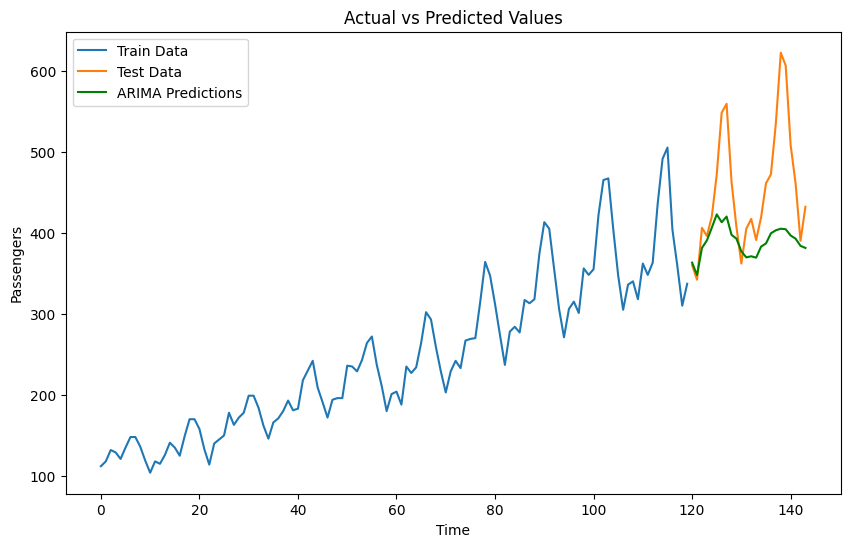

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train['Passengers'], label='Train Data')
plt.plot(Test.index, Test['Passengers'], label='Test Data')
plt.plot(arima_predictions.index, arima_predictions, color='green', label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Auto ARIMA

In [ ]:
stepwise_fit = auto_arima(Train['Passengers'], start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore', # we don't want to know if an order does not work
                          suppress_warnings = True, # we don't want convergence warnings
                          stepwise = True)     # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=811.075, Time=0.90 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=1.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.80 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=1.56 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.15 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.68 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.24 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.25 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Thu, 02 May 2024   AIC                            808.863
Time:                                    02:57:01   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

In [ ]:
print('Order :', best_order)
print('Seasonal Order :', best_seasonal_order)

Order : (2, 0, 0)
Seasonal Order : (0, 1, 0, 12)


## SARIMA

In [ ]:
# Fit a SARIMAX on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(Train['Passengers'],
                order = best_order,
                seasonal_order = best_seasonal_order)

sarima_result = model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -403.120
Date:                            Thu, 02 May 2024   AIC                            812.240
Time:                                    02:57:01   BIC                            820.287
Sample:                                         0   HQIC                           815.503
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7325      0.088      8.291      0.000       0.559       0.906
ar.L2          0.2189      0.093      2.358      0.018       0.037       0.401
sigma2       100.1812     11.847      8.456      0.000      76.961     123.402
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.99   Prob(JB):                         0.31
Heteroskedasticity (H):               1.36   Skew:                             0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecast
forecast_start = len(Train)
forecast_end = forecast_start + len(Test) - 1

# Generate predictions
sarima_predictions = sarima_result.predict(start = forecast_start,
                             end = forecast_end,
                             dynamic=False)

# Print the predictions
sarima_predictions

120    341.827283
121    319.557508
122    363.541020
123    349.469874
124    364.414147
125    436.357748
126    492.304231
127    506.252680
128    405.203199
129    360.155665
130    311.110011
131    338.066160
132    342.851324
133    320.541095
134    364.485749
135    350.377282
136    365.285708
137    437.194877
138    493.108290
139    507.024974
140    405.944984
141    360.868146
142    311.794345
143    338.723459
Name: predicted_mean, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Passengers"], sarima_predictions))

# Calculate root mean squared error
rmse_sarima = rmse(Test["Passengers"], sarima_predictions)
print('RMSE :', rmse_sarima)

MSE : 5664.3255732243315
RMSE : 75.26171386053025


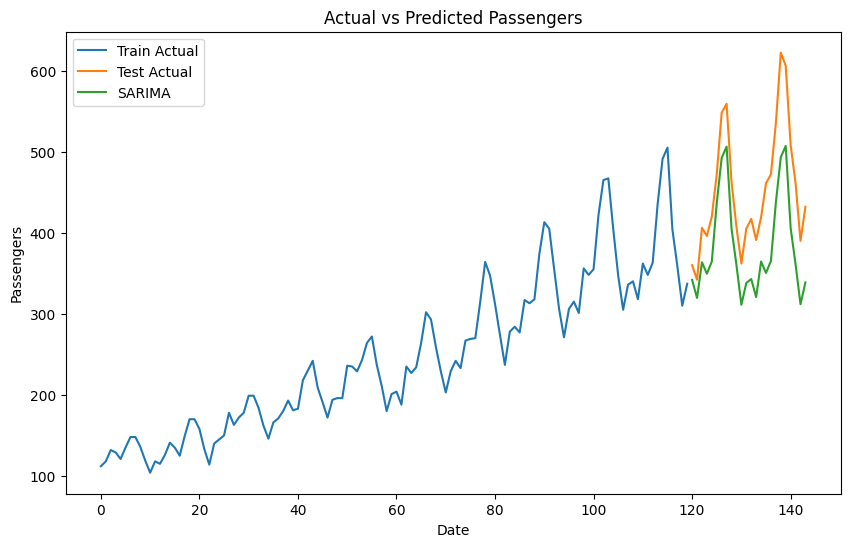

In [ ]:
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(Train.index, Train['Passengers'], label='Train Actual')
plt.plot(Test.index, Test['Passengers'], label='Test Actual')

# Plot predicted values
plt.plot(Test.index, sarima_predictions, label='SARIMA')

plt.title('Actual vs Predicted Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


In [ ]:
#Compare the results
data1 = {"MODEL":pd.Series(["SES", "Holt", 'hwe_model_add_add', 'hwe_model_mul_add', 'ARIMA', 'SARIMA']),
        "RMSE_Values":pd.Series([rmse_ses, rmse_hw_model, rmse_hwe_model_add_add, rmse_hwe_model_mul_add, rmse_arima, rmse_sarima])}
type(data1)

table_rmse1 = pd.DataFrame(data1)
table_rmse1.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
3,hwe_model_mul_add,32.488181
2,hwe_model_add_add,35.757539
5,SARIMA,75.261714
1,Holt,78.906853
4,ARIMA,88.151484
0,SES,107.518018


### Visualizing Models Performance

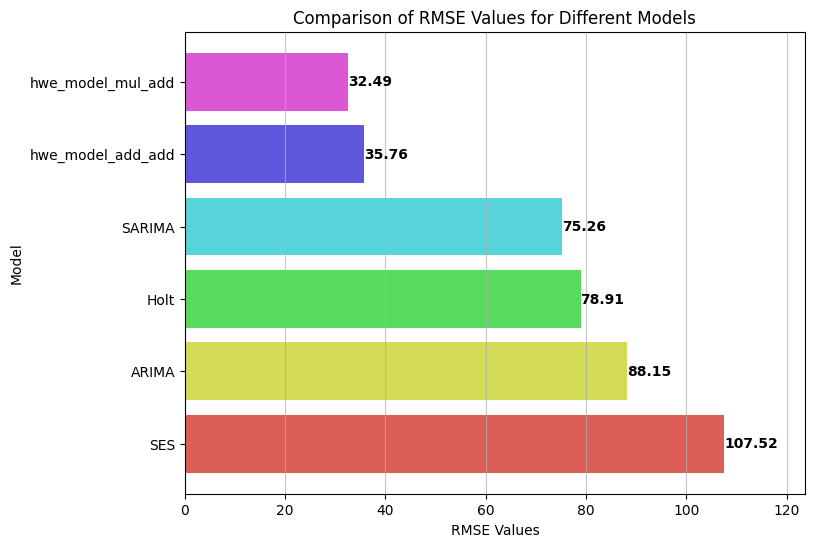

In [ ]:
# Sort DataFrame by RMSE values in ascending order
table_rmse1 = table_rmse1.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_rmse1))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_rmse1['MODEL'], table_rmse1['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_rmse1['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_rmse1['RMSE_Values']) * 1.15)

plt.show()

#   

## Training **Holt-Winters Triple Exponential Smoothing** model on entire data

In [ ]:
hwe_model_mul_add = ExponentialSmoothing(df["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

#### Forecasting for the next 2 years

In [ ]:
forecast_period = 24
hwe_model_mul_add_forecast = hwe_model_mul_add.forecast(steps=forecast_period)

# Print the forecast
print(hwe_model_mul_add_forecast)

144    445.242361
145    418.225341
146    465.309832
147    494.951245
148    505.475873
149    573.312666
150    663.596376
151    654.904046
152    546.760994
153    488.446831
154    415.723528
155    460.377815
156    474.071074
157    445.159419
158    495.116229
159    526.488038
160    537.513154
161    609.458560
162    705.215761
163    695.764708
164    580.697963
165    518.608285
166    441.262917
167    488.516423
dtype: float64


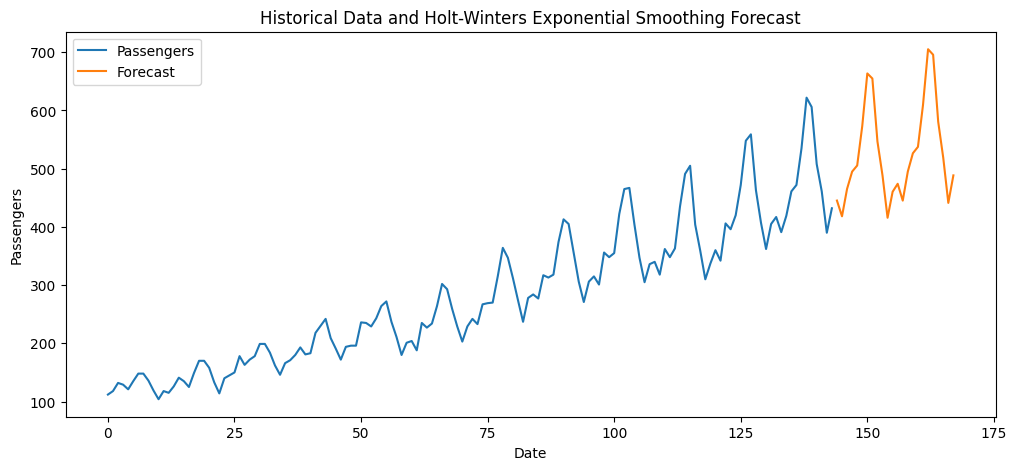

In [ ]:
# Plotting historical data
df['Passengers'].plot(figsize=(12, 5), legend=True)

# Plotting forecasted values
hwe_model_mul_add_forecast.plot(label='Forecast', legend=True)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Historical Data and Holt-Winters Exponential Smoothing Forecast')

# Show plot
plt.show()

#  

## Data Pre-processing for model driven techniques

In [ ]:
# Creating dummy columns for each month
dummy_months = pd.get_dummies(df['Month']).astype(int)

# Concatenating the dummy columns with the original DataFrame
df = pd.concat([df, dummy_months], axis=1)
df

,Month,Passengers,Date,Year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,Jan,112,1949-01-31,1949,0,0,0,0,1,0,0,0,0,0,0,0
1,Feb,118,1949-02-28,1949,0,0,0,1,0,0,0,0,0,0,0,0
2,Mar,132,1949-03-31,1949,0,0,0,0,0,0,0,1,0,0,0,0
3,Apr,129,1949-04-30,1949,1,0,0,0,0,0,0,0,0,0,0,0
4,May,121,1949-05-31,1949,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Aug,606,1960-08-31,1960,0,1,0,0,0,0,0,0,0,0,0,0
140,Sep,508,1960-09-30,1960,0,0,0,0,0,0,0,0,0,0,0,1
141,Oct,461,1960-10-31,1960,0,0,0,0,0,0,0,0,0,0,1,0
142,Nov,390,1960-11-30,1960,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
df['t'] = range(1, len(df) + 1)
df['log_passengers'] = np.log(df['Passengers'])
df['t_square'] = np.square(df['t'])

# Ordering the features
order = ['Date', 'Passengers', 't', 'log_passengers', 't_square', 'Year', 'Month', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df = df[order]
df

,Date,Passengers,t,log_passengers,t_square,Year,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1949-01-31,112,1,4.718499,1,1949,Jan,1,0,0,0,0,0,0,0,0,0,0,0
1,1949-02-28,118,2,4.770685,4,1949,Feb,0,1,0,0,0,0,0,0,0,0,0,0
2,1949-03-31,132,3,4.882802,9,1949,Mar,0,0,1,0,0,0,0,0,0,0,0,0
3,1949-04-30,129,4,4.859812,16,1949,Apr,0,0,0,1,0,0,0,0,0,0,0,0
4,1949-05-31,121,5,4.795791,25,1949,May,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-31,606,140,6.406880,19600,1960,Aug,0,0,0,0,0,0,0,1,0,0,0,0
140,1960-09-30,508,141,6.230481,19881,1960,Sep,0,0,0,0,0,0,0,0,1,0,0,0
141,1960-10-31,461,142,6.133398,20164,1960,Oct,0,0,0,0,0,0,0,0,0,1,0,0
142,1960-11-30,390,143,5.966147,20449,1960,Nov,0,0,0,0,0,0,0,0,0,0,1,0


## Data Partition

#### Utilizing the last 2 Years for Testing Purpose

In [ ]:
size = -24

# Partition the data into train and test sets
Train = df.iloc[:-24]
Test = df.iloc[-24:]

In [ ]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 120
Test set length: 24


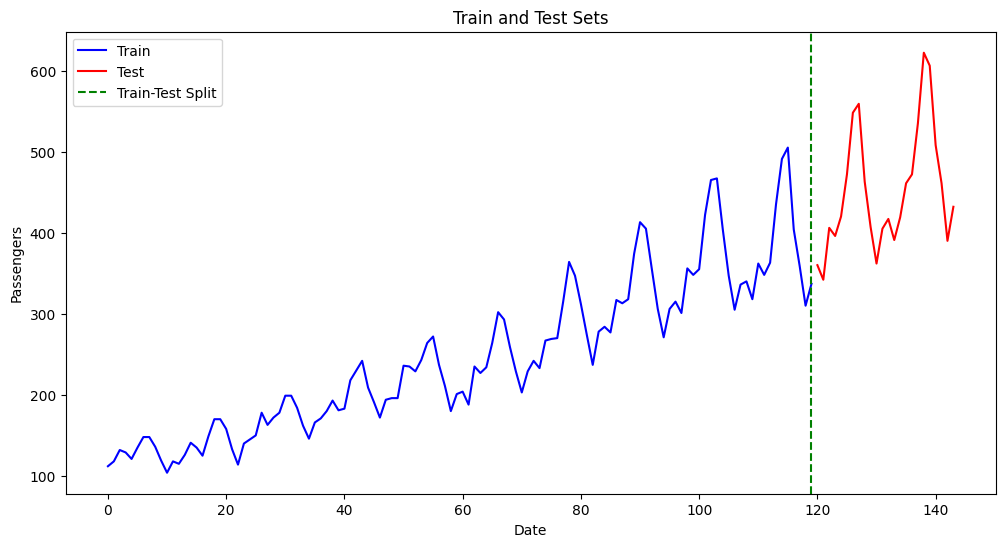

In [ ]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Passengers'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Passengers'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### **1. Linear model**

In [ ]:
import numpy as np
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print('Linear Model RMSE:',rmse_linear)

Linear Model RMSE: 74.78775885644497


In [ ]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     599.6
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.44e-48
Time:                        02:57:03   Log-Likelihood:                -607.85
No. Observations:                 120   AIC:                             1220.
Df Residuals:                     118   BIC:                             1225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.9661      7.103     13.370      0.000      80.900     109.032
t              2.4949      0.102     24.487      0.000       2.293       2.697
==============================================================================
Omnibus:                       17.280   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.930
Skew:                           0.833   Prob(JB):                     2.85e-05
Kurtosis:                       4.187   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

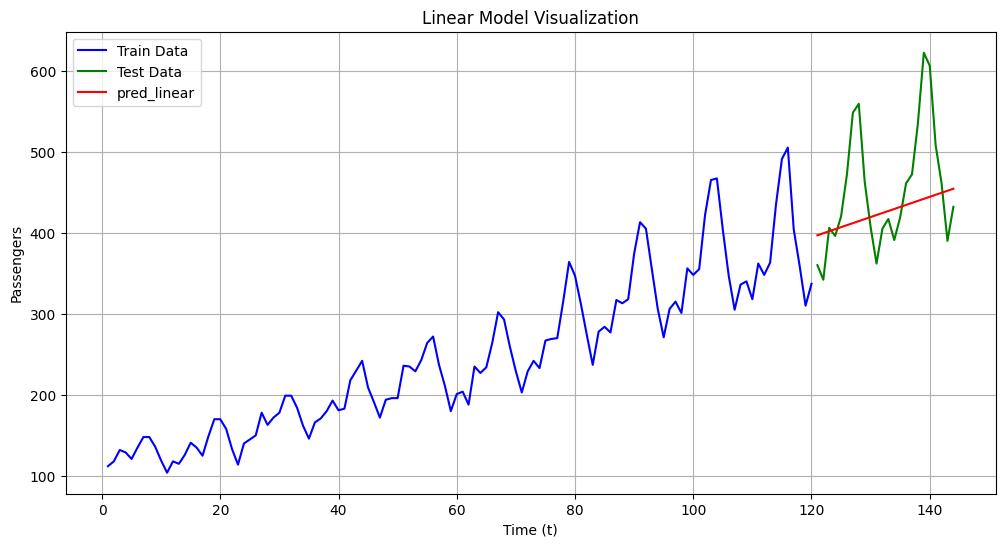

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color='green')

# Plot predicted values
plt.plot(Test['t'], pred_linear, label='pred_linear', color='red')

plt.title('Linear Model Visualization')
plt.xlabel('Time (t)')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### **2. Exponential model**

In [ ]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print('Exponential Model RMSE :',rmse_Exp)

Exponential Model RMSE : 79.20071462464722


In [ ]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     888.9
Date:                Thu, 02 May 2024   Prob (F-statistic):           9.06e-57
Time:                        02:57:04   Log-Likelihood:                 71.336
No. Observations:                 120   AIC:                            -138.7
Df Residuals:                     118   BIC:                            -133.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7902      0.025    193.624      0.000       4.741       4.839
t              0.0106      0.000     29.814      0.000       0.010       0.011
==============================================================================
Omnibus:                        2.553   Durbin-Watson:                   0.618
Prob(Omnibus):                  0.279   Jarque-Bera (JB):                1.755
Skew:                           0.060   Prob(JB):                        0.416
Kurtosis:                       2.420   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

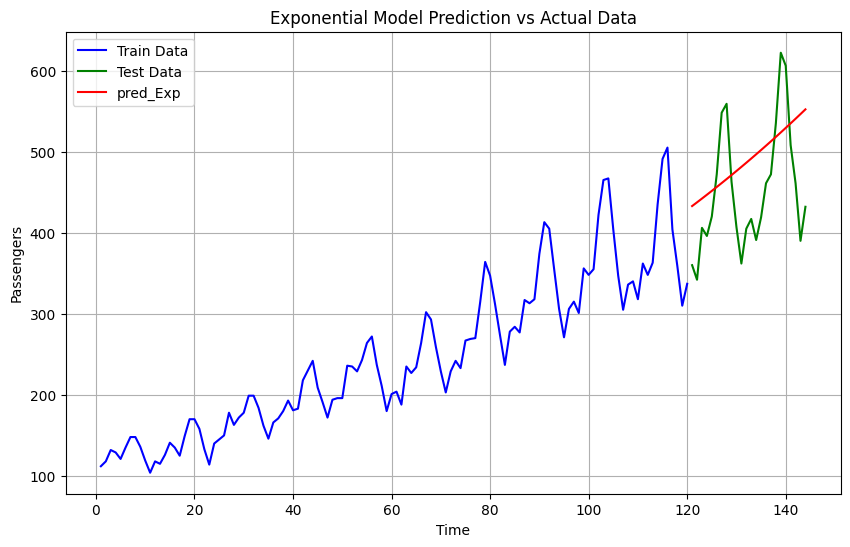

In [ ]:
# Creating visualization
plt.figure(figsize=(10, 6))

# Plotting train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color='green')

# Plotting predicted values from exponential model
plt.plot(Test['t'], np.exp(pred_Exp), label='pred_Exp', color='red')

plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Exponential Model Prediction vs Actual Data')
plt.legend()
plt.grid(True)
plt.show()

### **3. Quadratic Model**

In [ ]:
Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print('Quadratic RMSE :',rmse_Quad)

Quadratic RMSE : 69.12811109993947


In [ ]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     311.4
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.40e-47
Time:                        02:57:04   Log-Likelihood:                -605.51
No. Observations:                 120   AIC:                             1217.
Df Residuals:                     117   BIC:                             1225.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.1385     10.605     10.574      0.000      91.136     133.141
t              1.6504      0.405      4.079      0.000       0.849       2.452
t_square       0.0070      0.003      2.155      0.033       0.001       0.013
==============================================================================
Omnibus:                       12.921   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.520
Skew:                           0.681   Prob(JB):                     0.000703
Kurtosis:                       4.023   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

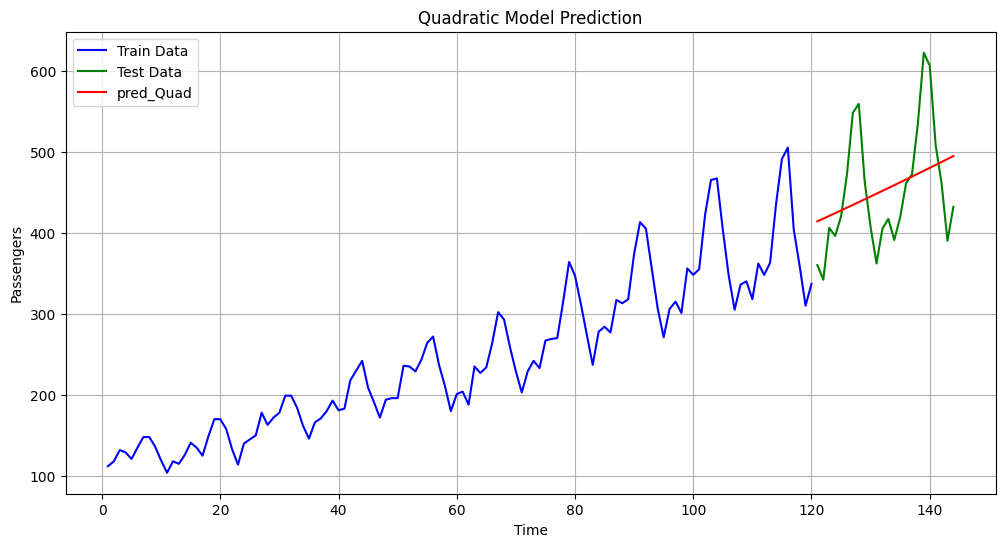

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color = 'blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color = 'green')

# Plotting predicted values for test data
plt.plot(Test['t'], pred_Quad, label='pred_Quad', color='red')

plt.title('Quadratic Model Prediction')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### **4. Additive Seasonality**

In [ ]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print('Additive Seasonality RMSE : ',rmse_add_sea)

Additive Seasonality RMSE :  211.38846744008194


In [ ]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.345
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.210
Time:                        02:57:05   Log-Likelihood:                -708.46
No. Observations:                 120   AIC:                             1441.
Df Residuals:                     108   BIC:                             1474.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    230.5000     29.555      7.799      0.000     171.917     289.083
Jan          -18.1000     41.797     -0.433      0.666    -100.950      64.750
Feb          -21.8000     41.797     -0.522      0.603    -104.650      61.050
Mar           11.2000     41.797      0.268      0.789     -71.650      94.050
Apr            4.3000     41.797      0.103      0.918     -78.550      87.150
May            6.5000     41.797      0.156      0.877     -76.350      89.350
Jun           42.8000     41.797      1.024      0.308     -40.050     125.650
Jul           74.1000     41.797      1.773      0.079      -8.750     156.950
Aug           74.3000     41.797      1.778      0.078      -8.550     157.150
Sep           35.3000     41.797      0.845      0.400     -47.550     118.150
Oct            2.6000     41.797      0.062      0.951     -80.250      85.450
Nov          -26.3000     41.797     -0.629      0.531    -109.150      56.550
==============================================================================
Omnibus:                       20.621   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.467
Skew:                           0.253   Prob(JB):                       0.0394
Kurtosis:                       1.982   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

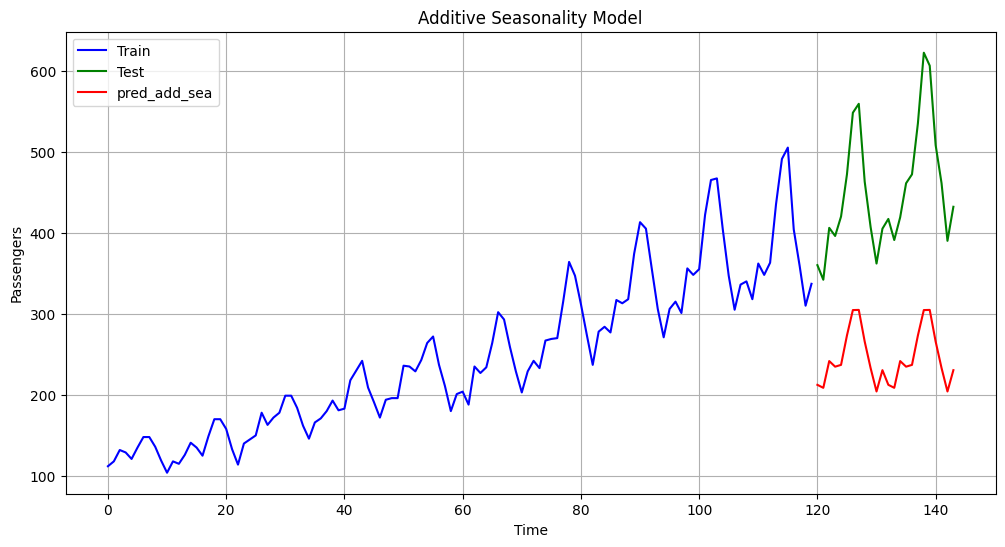

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot train and test data
plt.plot(Train['Passengers'], label='Train', color='blue')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['Passengers'], label='Test', color='green')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_add_sea, label='pred_add_sea', color='red')

plt.title('Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### **5. Additive Seasonality with Quadratic Trend**

In [ ]:
add_sea_Quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print('Additive Seasonality with Quadratic Trend RMSE :',rmse_add_sea_quad)

Additive Seasonality with Quadratic Trend RMSE : 38.62797034235329


In [ ]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     194.3
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.37e-67
Time:                        02:57:05   Log-Likelihood:                -523.45
No. Observations:                 120   AIC:                             1075.
Df Residuals:                     106   BIC:                             1114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9074      8.415      9.853      0.000      66.225      99.590
t              1.6311      0.215      7.601      0.000       1.206       2.057
t_square       0.0072      0.002      4.195      0.000       0.004       0.011
Jan            9.4310      9.048      1.042      0.300      -8.507      27.370
Feb            3.3002      9.045      0.365      0.716     -14.632      21.232
Mar           33.8551      9.042      3.744      0.000      15.929      51.781
Apr           24.4955      9.039      2.710      0.008       6.575      42.416
May           24.2215      9.037      2.680      0.009       6.305      42.138
Jun           58.0331      9.035      6.423      0.000      40.121      75.945
Jul           86.8302      9.033      9.613      0.000      68.922     104.739
Aug           84.5130      9.031      9.358      0.000      66.607     102.419
Sep           42.9814      9.030      4.760      0.000      25.078      60.885
Oct            7.7353      9.030      0.857      0.394     -10.167      25.637
Nov          -23.7251      9.029     -2.628      0.010     -41.626      -5.824
==============================================================================
Omnibus:                        2.119   Durbin-Watson:                   0.525
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.584
Skew:                           0.224   Prob(JB):                        0.453
Kurtosis:                       3.341   Cond. No.                     8.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

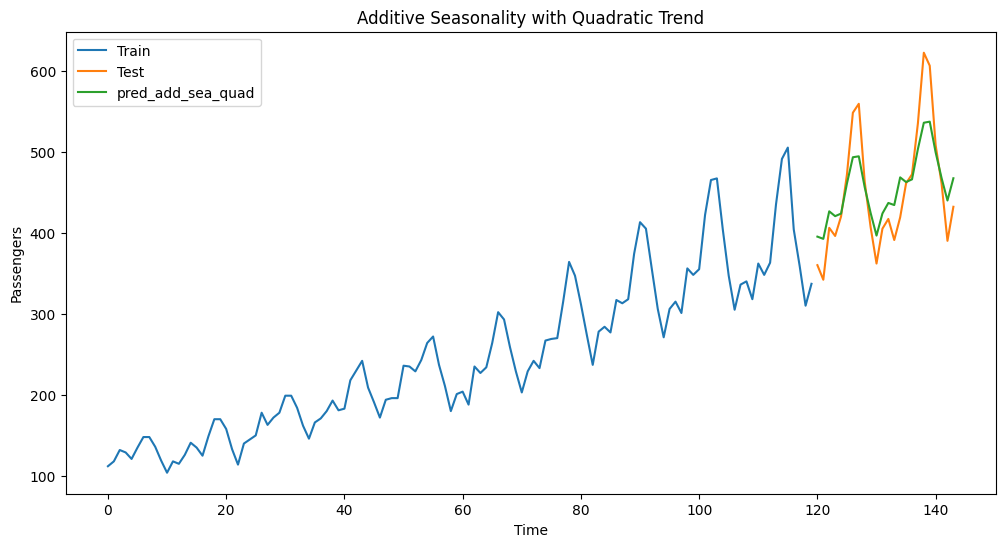

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Passengers'], label='Train')
plt.plot(Test.index, Test['Passengers'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_add_sea_quad, label='pred_add_sea_quad')

plt.title('Additive Seasonality with Quadratic Trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### **6. Multiplicative Seasonality**

In [ ]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print('Multiplicative Seasonality RMSE:',rmse_Mult_sea)

Multiplicative Seasonality RMSE: 227.56844750334858


In [ ]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.109
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.362
Time:                        02:57:05   Log-Likelihood:                -50.880
No. Observations:                 120   AIC:                             125.8
Df Residuals:                     108   BIC:                             159.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3818      0.123     43.666      0.000       5.137       5.626
Jan           -0.0920      0.174     -0.528      0.599      -0.438       0.253
Feb           -0.0948      0.174     -0.544      0.588      -0.440       0.251
Mar            0.0495      0.174      0.284      0.777      -0.296       0.395
Apr            0.0170      0.174      0.097      0.923      -0.329       0.362
May            0.0180      0.174      0.103      0.918      -0.328       0.363
Jun            0.1524      0.174      0.874      0.384      -0.193       0.498
Jul            0.2592      0.174      1.487      0.140      -0.086       0.605
Aug            0.2608      0.174      1.496      0.138      -0.085       0.606
Sep            0.1358      0.174      0.779      0.438      -0.210       0.481
Oct            0.0047      0.174      0.027      0.979      -0.341       0.350
Nov           -0.1273      0.174     -0.730      0.467      -0.473       0.218
==============================================================================
Omnibus:                       47.461   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.922
Skew:                          -0.169   Prob(JB):                       0.0190
Kurtosis:                       1.788   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

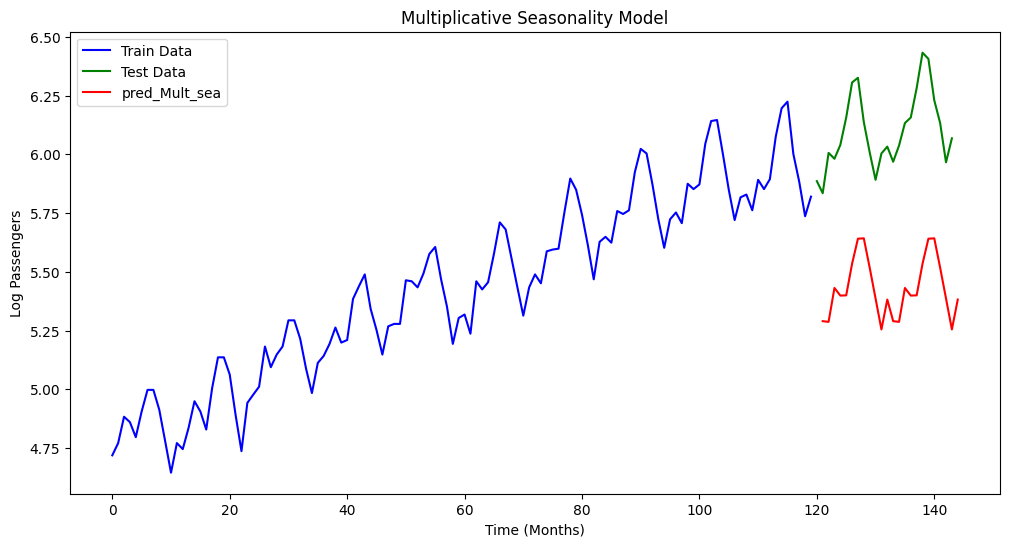

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting actual train and test data
plt.plot(Train['log_passengers'], label='Train Data', color='blue')
plt.plot(range(len(Train['log_passengers']), len(Train['log_passengers'])+len(Test['log_passengers'])),
         Test['log_passengers'], label='Test Data', color='green')

# Plotting predicted values
plt.plot(range(len(Train['log_passengers'])+1, len(Train['log_passengers'])+len(Test['log_passengers'])+1),
         pred_Mult_sea, label='pred_Mult_sea', color='red')

plt.xlabel('Time (Months)')
plt.ylabel('Log Passengers')
plt.title('Multiplicative Seasonality Model')
plt.legend()
plt.show()

### **7. Multiplicative Additive Seasonality**

In [ ]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print('Multiplicative Additive Seasonality RMSE :',rmse_Mult_add_sea)

Multiplicative Additive Seasonality RMSE : 46.87036076533804


In [ ]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     498.2
Date:                Thu, 02 May 2024   Prob (F-statistic):           5.70e-88
Time:                        02:57:06   Log-Likelihood:                 185.15
No. Observations:                 120   AIC:                            -344.3
Df Residuals:                     107   BIC:                            -308.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6807      0.020    236.494      0.000       4.641       4.720
t              0.0106      0.000     73.217      0.000       0.010       0.011
Jan            0.0248      0.025      1.012      0.314      -0.024       0.073
Feb            0.0114      0.025      0.464      0.643      -0.037       0.060
Mar            0.1451      0.025      5.913      0.000       0.096       0.194
Apr            0.1019      0.025      4.156      0.000       0.053       0.151
May            0.0923      0.025      3.765      0.000       0.044       0.141
Jun            0.2161      0.025      8.818      0.000       0.168       0.265
Jul            0.3123      0.025     12.744      0.000       0.264       0.361
Aug            0.3033      0.025     12.376      0.000       0.255       0.352
Sep            0.1676      0.025      6.842      0.000       0.119       0.216
Oct            0.0259      0.024      1.058      0.293      -0.023       0.074
Nov           -0.1166      0.024     -4.762      0.000      -0.165      -0.068
==============================================================================
Omnibus:                        3.463   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.283
Skew:                          -0.405   Prob(JB):                        0.194
Kurtosis:                       2.963   Cond. No.                         871.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

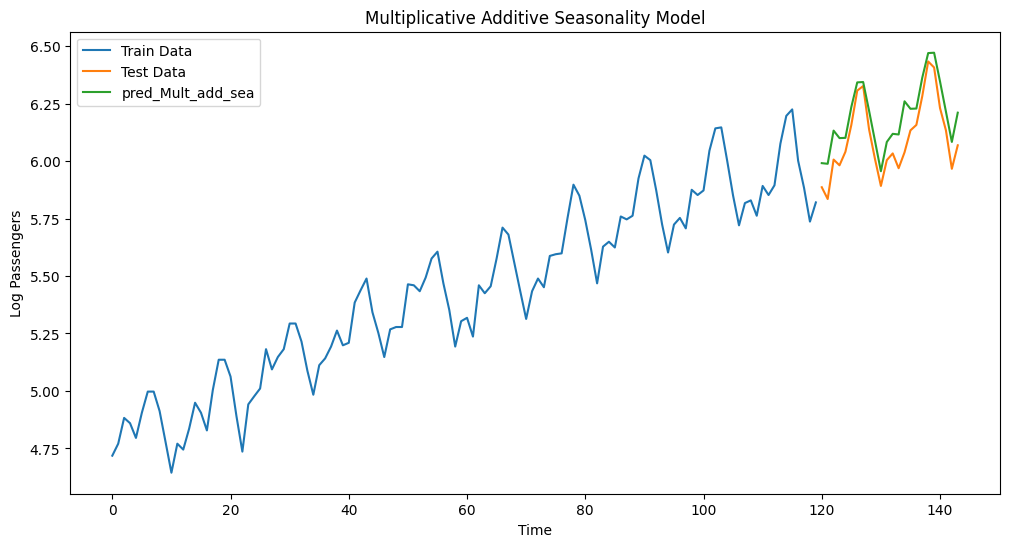

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['log_passengers'], label='Train Data')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['log_passengers'], label='Test Data')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_Mult_add_sea, label='pred_Mult_add_sea')

plt.title('Multiplicative Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

In [ ]:
#Compare the results
data2 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
         "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
type(data2)

table_rmse2 = pd.DataFrame(data2)
table_rmse2.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,38.627970
6,rmse_Mult_add_sea,46.870361
2,rmse_Quad,69.128111
0,rmse_linear,74.787759
1,rmse_Exp,79.200715
3,rmse_add_sea,211.388467
5,rmse_Mult_sea,227.568448


### RMSE table for all the models

In [ ]:
table_RMSE = pd.concat([table_rmse1, table_rmse2], ignore_index=True)

# Sorting concatenated DataFrame by RMSE_Values
table_RMSE = table_RMSE.sort_values(by='RMSE_Values')
table_RMSE

,MODEL,RMSE_Values
5,hwe_model_mul_add,32.488181
4,hwe_model_add_add,35.757539
10,rmse_add_sea_quad,38.627970
12,rmse_Mult_add_sea,46.870361
8,rmse_Quad,69.128111
6,rmse_linear,74.787759
3,SARIMA,75.261714
2,Holt,78.906853
7,rmse_Exp,79.200715
1,ARIMA,88.151484


### **Visualizing Models Performance**

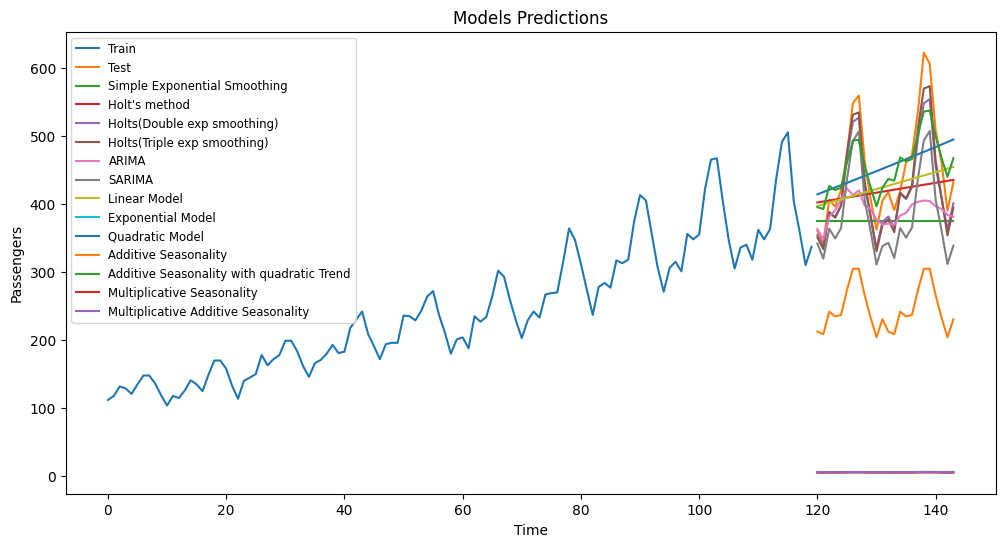

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Passengers'], label='Train')
plt.plot(Test.index, Test['Passengers'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_ses, label='Simple Exponential Smoothing')
plt.plot(Test.index, pred_hw, label="Holt's method")
plt.plot(Test.index, pred_hwe_add_add, label='Holts(Double exp smoothing)')
plt.plot(Test.index, pred_hwe_mul_add, label='Holts(Triple exp smoothing)')
plt.plot(Test.index, arima_predictions, label='ARIMA')
plt.plot(Test.index, sarima_predictions, label='SARIMA')
plt.plot(Test.index, pred_linear, label='Linear Model')
plt.plot(Test.index, pred_Exp, label='Exponential Model')
plt.plot(Test.index, pred_Quad, label='Quadratic Model')
plt.plot(Test.index, pred_add_sea, label='Additive Seasonality')
plt.plot(Test.index, pred_add_sea_quad, label='Additive Seasonality with quadratic Trend')
plt.plot(Test.index, pred_Mult_sea, label='Multiplicative Seasonality')
plt.plot(Test.index, pred_Mult_add_sea, label='Multiplicative Additive Seasonality')

plt.title('Models Predictions')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(loc = 'best', fontsize='small')
plt.show()

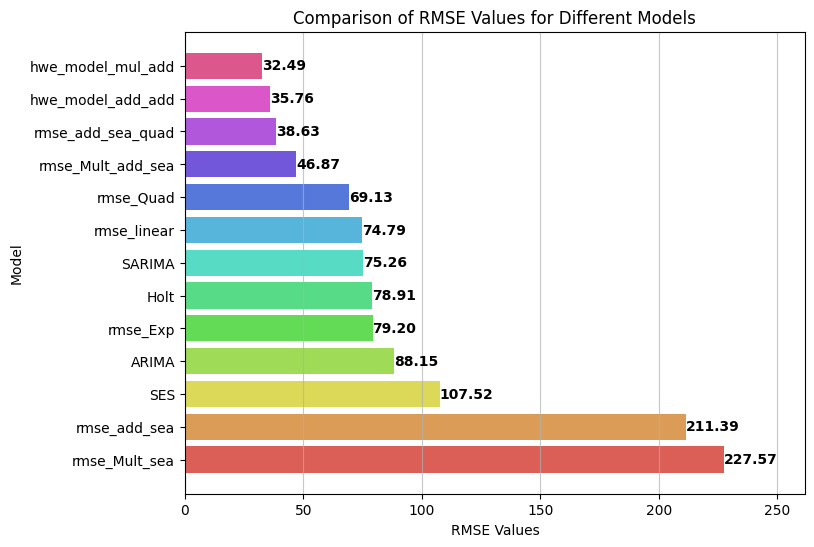

In [ ]:
table_RMSE = table_RMSE.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_RMSE))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_RMSE['MODEL'], table_RMSE['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_RMSE['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_RMSE['RMSE_Values']) * 1.15)
plt.show()

# **Conclusion :**

## **Holt-Winters Triple Exponential Smoothing** has the lowest RMSE, making it our best model so far.